# Purpose

* Want to evaluate what factors contribute to a phone's sale price

In [114]:
%load_ext nb_black
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [115]:
df = pd.read_csv(r'C:\Users\ventu\Python\Data_Science_Projects\Used Phones\storage.csv',index_col=[0])
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# Dropping columns that require NLP for now
df = df.drop(['Listing', 'Title', 'Description', 'ExpiredDate', 'Damage'], axis=1)
df = df[df.Sold.notnull() == True]
df = df.reset_index(drop=True)

C:\Users\ventu\.conda\envs\data\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>

## Useful Functions

In [116]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    Transform categorical variables using one hot encoding and outputs dataframe with original variable replaced by dummy variables.
    :Params:
        :original_dataframe: pandas dataframe
        :feature_to_encode: string name of column to be encoded
    :Returns
        :dataframe with original column removed and nominal encoding set
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

<IPython.core.display.Javascript object>

## Preprocessing

### 1. Data Type Transformations
* Transform numeric string values into numeric
* Encode Categorical Variables
* Change string dates to dateime

In [117]:
# Removes the GB from storage and turns it into an int (could think about using this as categorical instead)
df.Storage = df.Storage.apply(lambda x: int(re.sub("[^0-9]", "", x)))

# Changing string dates into datetime format
df.ListDate = pd.to_datetime(df.ListDate, format="%b %d, %Y")
df.SaleDate = pd.to_datetime(df.SaleDate, format="%b %d, %Y")
# df.ExpiredDate = pd.to_datetime(df.ExpiredDate, format="%b %d, %Y")

# Fill in empty values for one hot encoding
# df.Sold.fillna('No', inplace=True)

# Categorize low count numbers together otherwise suspectible to overfitting
color_freq = df.Color.value_counts()
low_freq_colors = color_freq[color_freq.values < int(len(df)/30)]
df.Color = df.Color.apply(lambda x: 'Other' if x in low_freq_colors else x)

# Used later in attempt to improve model
df2 = df

<IPython.core.display.Javascript object>

### 2. Categorical Variables Encoding
* Check value counts of each categorical variable
* Apply one hot encoding to categorical variables

AxesSubplot(0.125,0.125;0.775x0.755)


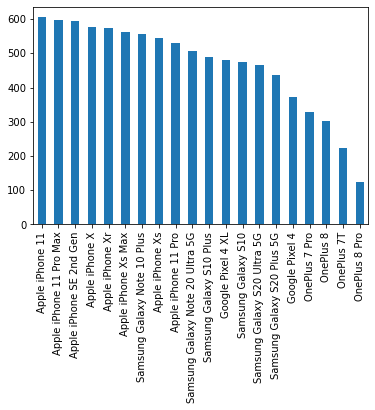

AxesSubplot(0.125,0.125;0.775x0.755)


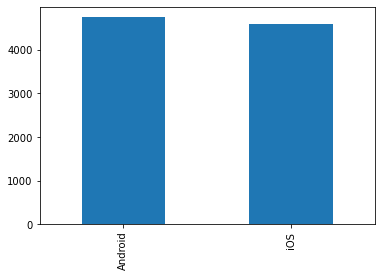

AxesSubplot(0.125,0.125;0.775x0.755)


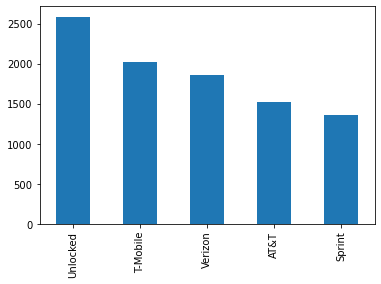

AxesSubplot(0.125,0.125;0.775x0.755)


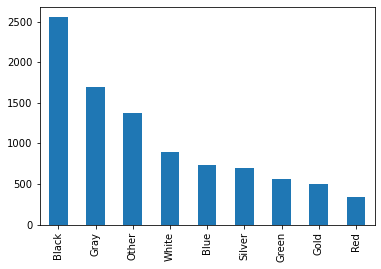

AxesSubplot(0.125,0.125;0.775x0.755)


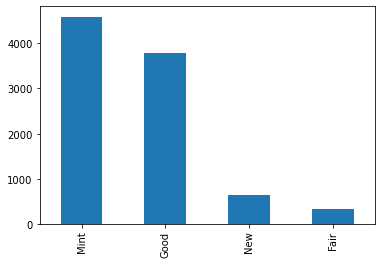

AxesSubplot(0.125,0.125;0.775x0.755)


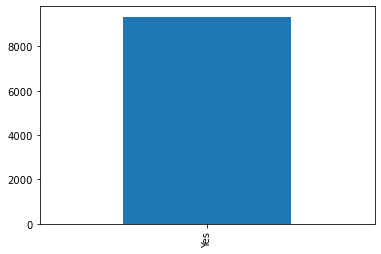

<IPython.core.display.Javascript object>

In [118]:
# Check the distribution of each variable
cat = df.select_dtypes(include=['object']).columns.tolist()
for cols in cat:
    print(df[cols].value_counts().plot(kind='bar'))
    plt.show()

In [124]:
df3 = df.loc[df['Sold']=='Yes'].groupby('Model').Price.mean()

import plotly.graph_objects as go

fig = go.Figure(go.Bar(
    orientation="h",
    x = df3.values,
    y = df3.index))

fig.update_layout(
    autosize=False,
    height=600,
    yaxis={'categoryorder':'total ascending', 'title':'Model'},
    xaxis={'title':'Price'},
    title='Phone Average Sale Price',
)

fig.show()

<IPython.core.display.Javascript object>

In [105]:
# One Hot Encoding categorical variables
for cols in cat:
    df = encode_and_bind(df, cols)

<IPython.core.display.Javascript object>

### 3. Linear Regression and XGBoost

In [106]:
# Quick and dirty version excluding dates
X, y = df.drop(['Price','ListDate', 'SaleDate'], axis=1), df['Price']

# Setup for our regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Setting up cross validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=21)

# Quicker Pipeline method
linear_pipeline = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])
# Cross validation 
linear_scores = cross_val_score(linear_pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
linear_scores = np.abs(linear_scores)
print('Mean MAE: %.3f (%.3f)' % (linear_scores.mean(), linear_scores.std()))

Mean MAE: 36.971 (0.692)


<IPython.core.display.Javascript object>

In [107]:

# Setup pipeline to feed model
xg_pipeline = Pipeline([('scaler', StandardScaler()),('model', XGBRegressor())])
# Evaluation methodology
xg_scores = cross_val_score(xg_pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
xg_scores = np.abs(xg_scores)
print('Mean MAE: %.3f (%.3f)' % (xg_scores.mean(), xg_scores.std()))

Mean MAE: 31.419 (0.700)


<IPython.core.display.Javascript object>

Interesting to note that our simple Linear Regression model is outperforming XGBoost. 

### 4. Attempts to improve score
* Remove some of the less popular models (OnePlus)
* Remove Colors

In [108]:
df2 = df2.drop(['Color', 'SaleDate', 'ListDate', 'Quantity', 'Views'], axis=1)
df2 = df2[df2['Model'].str.contains('Apple|Samsung')]
df2 = df2[df2['Condition'].str.contains('Mint|Good')]

<IPython.core.display.Javascript object>

In [109]:
# One Hot Encoding categorical variables
cat2 = df2.select_dtypes(include=['object']).columns.tolist()
for cols in cat2:
    df2 = encode_and_bind(df2, cols)

<IPython.core.display.Javascript object>

In [110]:
X2, y2 = df2.drop(['Price'], axis=1), df2['Price']

<IPython.core.display.Javascript object>

In [111]:
# Quicker Pipeline method
linear_pipeline = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])
# Cross validation 
linear_scores = cross_val_score(linear_pipeline, X2, y2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
linear_scores = np.abs(linear_scores)
print('Mean MAE: %.3f (%.3f)' % (linear_scores.mean(), linear_scores.std()))

Mean MAE: 37.702 (0.850)


<IPython.core.display.Javascript object>

In [112]:
# Setup pipeline to feed model
xg_pipeline = Pipeline([('scaler', StandardScaler()),('model', XGBRegressor())])
# Evaluation methodology
xg_scores = cross_val_score(xg_pipeline, X2, y2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
xg_scores = np.abs(xg_scores)
print('Mean MAE: %.3f (%.3f)' % (xg_scores.mean(), xg_scores.std()))

Mean MAE: 34.957 (0.843)


<IPython.core.display.Javascript object>

Slight improvement but model is also less useful.